In [1]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import openpyxl

import os
import requests
from lxml import html
from bs4 import BeautifulSoup
import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import urbanpy as up
import contextily as ctx

import io

pd.set_option('display.max_rows',999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings("ignore")
#import unicodedata
#import gzip

In [2]:
distances = pd.read_excel('C:/Users/Franco/Python/CAF/files/distances.xlsx', index_col = 0)

In [3]:
cwpops = pd.read_excel('C:/Users/Franco/Python/CAF/files/cwpops.xlsx', index_col = [0,1])

In [4]:
ejd = pd.read_excel('C:/Users/Franco/Python/CAF/files/analisis_ejd.xlsx',  sheet_name='Sheet1 (2)')

In [5]:
ejd = ejd.rename(columns={'Pais':'Country','Ciudad':'City'})

In [6]:
#Creo DICT para poder cambiar las siglas de los paises por los nomrbes de los paises

a = list(ejd.loc[:,'Country'].unique())

b = [
 'Brasil',
 'Costa Rica',
 'Argentina',
 'Paraguay',
 'Uruguay',
 'Mexico',
 'Peru',
 'Ecuador',
 'Bolivia',
 'Panama',
 'Venezuela',
 'Chile',
 'Colombia']

b = sorted(b)

nombres = dict(zip(a, b))

nombres['PER'] = 'Peru'
nombres['PRY'] = 'Paraguay'

In [7]:
ejd = ejd.replace({"Country": nombres}).set_index(['Country','City'])

In [8]:
ejd = ejd.reset_index()

In [9]:
ejd.loc[ejd['Country']=='Mexico','City'] = ejd.loc[ejd['Country'] == 'Mexico']['City'].str.replace('Zona metropolitana de ','').str.replace('Zona metropolitana del ','')

In [10]:
ejd = ejd.set_index(['Country','City'])

In [11]:
#a = cwpops.loc['Mexico'].join(ejd.loc['Mexico'],how='inner').index.tolist()

#cwpops.loc['Mexico'].join(ejd.loc['Mexico'],how='outer').drop(index=a)

In [12]:
dic = pd.read_excel('C:/Users/Franco/Python/CAF/files/Diccionario.xlsx',header=1,usecols='B',nrows=10)

dic.columns = ['actividad']

dic['sn'] = 's' + dic['actividad'].str[:2]

dic['sn'] = dic['sn'].str.replace(" ","")

dic['actividad'] = dic['actividad'].str[5:]

dic = dic.rename(columns={'sn':'principal_sector'})

Nueva base Garganta: eph

In [13]:
eph = pd.read_excel('c:/Users/Franco/Python/CAF/files/eph/{}'.format(os.listdir("c:/Users/Franco/Python/CAF/files/eph")[2]),header=[4,5]).dropna(how='all').dropna(axis=1,how='all')

In [14]:
eph = eph.drop(columns=eph.columns[:3].tolist())

In [15]:
#eph = pd.read_excel('c:/Users/Franco/Python/CAF/files/eph/{}'.format(os.listdir("c:/Users/Franco/Python/CAF/files/eph")[3]),header=[0,1]) # ,usecols=list(range(2,43))

In [16]:
#eph = eph.dropna(how='all').dropna(axis=1,how='all')

In [17]:
eph[('Country','Country')] = np.nan

In [18]:
eph = eph.rename(columns={'Unnamed: 3_level_1':'City'},level=1).rename(columns={'Unnamed: 3_level_0':'City'},level=0)

In [19]:
eph = eph.rename(columns={'Unnamed: 4_level_0':'Salario Horario (PPP 2011)'},level=0)

In [20]:
eph.loc[(eph[('City','City')].str.contains('total ciudades')),('Country','Country')] = eph.loc[(eph[('City','City')].str.contains('total ciudades')),('City','City')].apply(lambda x: x.split(' ',1)[0])

In [21]:
eph[('Country','Country')] = eph[('Country','Country')].ffill()

In [22]:
eph.loc[eph[('Country','Country')]=='Mexico',('City','City')] = eph.loc[eph[('Country','Country')] == 'Mexico'][('City','City')].str.replace('Zona metropolitana de ','').str.replace('Zona metropolitana del ','')

In [23]:
eph[('City','City')][eph[('Country','Country')]=='Colombia']=eph[('City','City')].str.title()

In [24]:
eph = eph.replace({('City','City'):{'Pedro Domingo Murillo (La Paz y el Alto)':'Pedro Domingo Murillo/La Paz y el Alto','Tomas Frías':'Tomas Frías/Potosí','Panama Oeste Arraiján':'Panama Arraiján','Panama Oeste La Chorrera':'Panama La Chorrera','chincha/Chincha Alta':'Chincha/Chincha Alta'}})

In [25]:
#eph.loc[:,[('Country','Country'),('City','City')]].droplevel(level=0,axis=1)
#eph[[('Country','Country'),('City','City')]] = 
#eph[[('Country','Country'),('City','City')]].droplevel(level=1,axis=1)
eph['pais'] = eph[('Country','Country')].to_frame().droplevel(level=0,axis=1)
eph['ciudad'] = eph[('City','City')].to_frame().droplevel(level=0,axis=1)

In [26]:
eph = eph.drop(columns=[('Country','Country'),('City','City')]).rename(columns={'pais':'Country','ciudad':'City'}).set_index(['Country','City'])

### Base cutoff

In [27]:
def get_wages_from_cutoff(city_index, cutoff):
    city_wage = cwpops.drop_duplicates('index1').loc[city_index]['estimated_citywage']
    distan = distances[(distances['Country'] == city_index[0])
                            &(distances['City A'] == city_index[1])
                            &(distances['parsed_duration'] <= cutoff)].drop_duplicates('City B')

    nearby_cities = [(x,y) for x,y in distan[['Country','City B']].values.tolist()]
    if len(nearby_cities) == 0:
        return city_wage
    else:
        nearby_wages = cwpops.loc[nearby_cities]['estimated_citywage'].sum()
        return nearby_wages + city_wage

In [28]:
def get_countryshare_from_cutoff(city_index, cutoff, share_out = True):
    nearwages = get_wages_from_cutoff(city_index, cutoff = cutoff)
    country_wages = cwpops.groupby('Country')['estimated_citywage'].sum().loc[city_index[0]]
    share = nearwages/country_wages
    if share_out == True:
        return share
    else:
        return nearwages

In [29]:
shares_cutoff = pd.DataFrame(index = cwpops.index)

In [30]:
shares_cutoff['index1'] = shares_cutoff.index
for i in range(10):
    shares_cutoff['cutoff_' + str(i)] = shares_cutoff['index1'].apply(lambda x: get_countryshare_from_cutoff(x , cutoff = i))

In [31]:
shares_cutoff = pd.concat([shares_cutoff, shares_cutoff.mean().to_frame(('Promedios','Promedios')).T])

### Acomodar el tema 'Distances' a km

In [32]:
distances['Distance2'] = distances['Distance']

In [33]:
distances.loc[(distances['Distance'].str.contains(' ft| m')),'Distance2'] = '0 km'

In [34]:
distances['distance_km'] = distances['Distance2'].apply(lambda x: x.replace(' km',''))

In [35]:
distances['distance_km'] = distances['distance_km'].astype('float')

In [36]:
del distances['Distance2']

Parsed time in traffic

In [37]:
distances['dit_elementos'] = distances['Duration in traffic'].apply(lambda x: len(re.split('day|hour|mins|seconds',x)))

In [38]:
distances['duration_traffic'] = np.nan

for i, row in distances.iterrows():
    if 'second' in row['Duration in traffic']:
        distances.loc[i,'duration_traffic']  = float(0)
    elif 'mins' in row['Duration in traffic'] and 'hour' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic']  = float('0.'+row['Duration in traffic'].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic']  = float('0.0'+row['Duration in traffic'].replace(' mins',''))*100/60
    elif 'hour' in row['Duration in traffic'] and 'day' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].split(' hour ')[1].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.0'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
    elif 'day' in row['Duration in traffic']:
        a = re.split(' day | hour | mins',row['Duration in traffic'])
        if len(a[2]) > 1:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.'+a[2])*100/60
        else:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.0'+a[2])*100/60

### Reveer tema de Criterio

#### Sectores

In [45]:
#ver como importar eph
#eph = pd.read_excel('files/eph/Indicadores_LAC_v1.xlsx')

In [46]:
"""
ta = pd.read_excel('files/tabla_ancha.xlsx',index_col=[0,1])

keys = ta.index.get_level_values(0).unique().tolist()

values = cwpops.index.get_level_values(0).unique().tolist()

a = values[-3]
b = values[-2]

values[-3] = b
values[-2] = a

mydict = dict(zip(keys,values))

ta = ta.reset_index().replace({'pais':mydict}).rename(columns={'pais':'Country','Ciudad':'City'}).set_index(['Country','City'])

ta.join(cwpops.iloc[:,:2],how='inner').shape

ta.shape
"""

"\nta = pd.read_excel('files/tabla_ancha.xlsx',index_col=[0,1])\n\nkeys = ta.index.get_level_values(0).unique().tolist()\n\nvalues = cwpops.index.get_level_values(0).unique().tolist()\n\na = values[-3]\nb = values[-2]\n\nvalues[-3] = b\nvalues[-2] = a\n\nmydict = dict(zip(keys,values))\n\nta = ta.reset_index().replace({'pais':mydict}).rename(columns={'pais':'Country','Ciudad':'City'}).set_index(['Country','City'])\n\nta.join(cwpops.iloc[:,:2],how='inner').shape\n\nta.shape\n"

In [35]:
os.listdir(os.getcwd()+'/files/tabla ancha 2')[0]

'tabla_ancha.xlsx'

In [36]:
ta = pd.read_excel('files/tabla ancha 2/'+os.listdir(os.getcwd()+'/files/tabla ancha 2')[0],sheet_name='HH')

In [37]:
keys = ta['pais2'].unique().tolist()

In [38]:
values = [keys[e].title() for e in range(len(keys))]

In [39]:
mydict = dict(zip(keys,values))

In [40]:
ta = ta.replace({'pais2':mydict})

In [41]:
ta = ta.rename(columns={'pais2':'Country','Ciudad':'City'}).set_index(['Country','City'])

In [42]:
ta2 =  ta.iloc[:,33:43].join(ta.iloc[:,33:43].groupby('Country').mean(),how='inner',rsuffix='_promedio')

In [43]:
count=0
for l,c in ta2.iteritems():
    ta2['ratio_{}'.format(l)] = ta2[l]/ta2['{}_promedio'.format(l)]
    count += 1
    if count == 10:
        break

In [44]:
ta3 = ta2.iloc[:,-10:]

In [45]:
ta3 = ta3.reset_index().replace({'City':{'Pedro Domingo Murillo (La Paz y el Alto)':'Pedro Domingo Murillo/La Paz y el Alto','Tomas Frías':'Tomas Frías/Potosí','Panama Oeste Arraiján':'Panama Arraiján','Panama Oeste La Chorrera':'Panama La Chorrera','chincha/Chincha Alta':'Chincha/Chincha Alta'}})

In [46]:
ta3['City'][ta3['Country']=='Colombia']=ta3['City'].str.title()

In [47]:
ta3.loc[ta3['Country']=='Mexico','City'] = ta3['City'][ta3['Country']=='Mexico'].str.replace('Zona metropolitana de ','').str.replace('Zona metropolitana del ','')

In [48]:
ta3 = ta3.set_index(['Country','City'])

In [49]:
#ta3.iloc[:,2]
#msa_latam.groupby('Country').head(3).sort_values(['Country','City'])
sectores = cwpops.loc[:,['pops','masalarial','estimated_citywage']].join(ta3.iloc[:,:3],how='inner')

In [50]:
sectores.shape

(274, 6)

In [167]:
merge = ta3.iloc[:,:3].merge(cwpops.loc[:,['pops','masalarial','estimated_citywage']],how='left',left_index=True,right_index=True,indicator=True)
merge[merge['_merge']=='left_only']

ratio_Agro  ratio_Baja Tec  \
Country  City                                                             
Mexico   León                                     0.174           3.418   
Panama   Panama Resto de la Prov. De Panama       1.010           1.087   
Paraguay San Pedro                                1.445           0.876   
Uruguay  Rio Branco                               1.013           1.056   
         Trinidad                                 1.078           0.798   

                                             ratio_Resto Ind  pops  \
Country  City                                                        
Mexico   León                                          0.833   nan   
Panama   Panama Resto de la Prov. De Panama            1.362   nan   
Paraguay San Pedro                                     0.441   nan   
Uruguay  Rio Branco                                    0.674   nan   
         Trinidad                                      0.430   nan   

                                             masalarial  estimated_citywage  \
Country  City                                                                 
Mexico   León                                       nan                 nan   
Panama   Panama Resto de la Prov. De Panama         nan                 nan   
Paraguay San Pedro                                  nan                 nan   
Uruguay  Rio Branco                                 nan                 nan   
         Trinidad                                   nan                 nan   

                                                _merge  
Country  City                                           
Mexico   León                                left_only  
Panama   Panama Resto de la Prov. De Panama  left_only  
Paraguay San Pedro                           left_only  
Uruguay  Rio Branco                          left_only  
         Trinidad                            left_only

Agro

In [51]:
sectores.sort_values(['Country','ratio_Agro'],ascending=[True,False]).loc[(sectores['pops']>500000)&(sectores['pops']<5000000),['pops','ratio_Agro']].groupby('Country').head(3)

pops  ratio_Agro
Country    City                                                       
Argentina  Gran Tucuman-Tafi Viejo                 1448188       0.959
           Mar del Plata-Batan                      656456       0.746
           Ciudad de Buenos Aires                  3075646       0.403
Bolivia    Andrés Ibañez/Santa Cruz de la Sierra   3151676       0.731
           Cercado/Cochabamba                      1916000       0.505
           Pedro Domingo Murillo/La Paz y el Alto  2867504       0.295
Brasil     Goiania                                 1302000       2.722
           Campo Grande                             774202       1.898
           Fortaleza                               2643000       1.336
Colombia   Bucaramanga                              581130       1.593
           Villavicencio                            527668       1.532
           Armenia                                 2959694       1.363
Costa Rica Liberia                                 4818977       0.902
Ecuador    Esmeraldas                               643654       0.753
           Guayaquil                               2291000       0.453
           Quito                                   1619000       0.323
Mexico     Mexicali                                 689775       3.790
           La Laguna                               1215817       2.102
           Hermosillo                               812229       1.923
Paraguay   Itapúa                                   608215       3.080
           Asunción                                 525294       0.334
           Alto Paraná                              830943       0.234
Peru       Arequipa -area metropolitana            1008000       0.658
           Chiclayo                                 552508       0.652
           Trujillo                                 919899       0.291
Uruguay    Montevideo                              1381000       0.241

In [53]:
agrolist=['Gran Tucuman-Tafi Viejo'
,'Goiania'
,'Campo Grande'
,'Villavicencio'
,'Armenia'
#,'Mexicali'
,'La Laguna'
,'Hermosillo'
,'Itapúa']

In [54]:
sel_agro = cwpops.loc[cwpops.index.get_level_values(1).isin(agrolist),['pops']].join(shares_cutoff.loc[:,'cutoff_8'],how='inner').join(
    eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').rename(columns={'cutoff_8':'% m. salarial en < 8hs','pops':'Población estimada',
    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('Duración desempleo (meses)', 'Total'):'Duración desempleo',
    ('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)',
    'Salario Horario (PPP 2011)'):'Salario Hora (PPP 2011)'}).join(sectores['ratio_Agro']).rename(columns={'ratio_Agro':'Relación MS Agro ( Ciudad / País )'})

In [55]:
sel_agro['Población estimada'] = sel_agro['Población estimada'].apply(lambda x : "{:,}".format(x))
sel_agro['% m. salarial en < 8hs'] = sel_agro['% m. salarial en < 8hs'].apply(lambda x :x*100)

In [56]:
cols = sel_agro.columns.tolist()

cols = [cols[0]] + [cols[-1]] + cols[2:-1] + [cols[1]]

In [57]:
sel_agro = sel_agro[cols]

In [380]:
sel_agro.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/images/agro.html')

In [58]:
sel_agro

Población estimada  \
Country   City                                         
Argentina Gran Tucuman-Tafi Viejo          1,448,188   
Brasil    Campo Grande                       774,202   
          Goiania                          1,302,000   
Colombia  Armenia                          2,959,694   
          Villavicencio                      527,668   
Mexico    Hermosillo                         812,229   
          La Laguna                        1,215,817   
Paraguay  Itapúa                             608,215   

                                   Relación MS Agro ( Ciudad / País )  \
Country   City                                                          
Argentina Gran Tucuman-Tafi Viejo                               0.959   
Brasil    Campo Grande                                          1.898   
          Goiania                                               2.722   
Colombia  Armenia                                               1.363   
          Villavicencio                                         1.532   
Mexico    Hermosillo                                            1.923   
          La Laguna                                             2.102   
Paraguay  Itapúa                                                3.080   

                                   Salario Hora (PPP 2011)  % informalidad  \
Country   City                                                               
Argentina Gran Tucuman-Tafi Viejo                    4.454          47.714   
Brasil    Campo Grande                               5.548          23.169   
          Goiania                                    4.752          23.668   
Colombia  Armenia                                    3.393          31.333   
          Villavicencio                              3.608          35.294   
Mexico    Hermosillo                                 5.291          44.842   
          La Laguna                                  4.058          45.863   
Paraguay  Itapúa                                     5.780          64.672   

                                   % desempleo  % Secundario Completo  \
Country   City                                                          
Argentina Gran Tucuman-Tafi Viejo       10.321                 42.952   
Brasil    Campo Grande                   8.086                 38.189   
          Goiania                       10.999                 40.484   
Colombia  Armenia                        7.870                 36.443   
          Villavicencio                  8.242                 40.838   
Mexico    Hermosillo                     3.458                 36.755   
          La Laguna                      4.140                 29.628   
Paraguay  Itapúa                         3.695                 40.267   

                                   % Superior Completo  % m. salarial en < 8hs  
Country   City                                                                  
Argentina Gran Tucuman-Tafi Viejo               10.203                  13.371  
Brasil    Campo Grande                          13.157                   3.962  
          Goiania                               11.149                   6.143  
Colombia  Armenia                                8.642                  75.809  
          Villavicencio                          8.776                  41.701  
Mexico    Hermosillo                            14.938                   7.171  
          La Laguna                             12.378                  38.500  
Paraguay  Itapúa                                13.336                  33.742

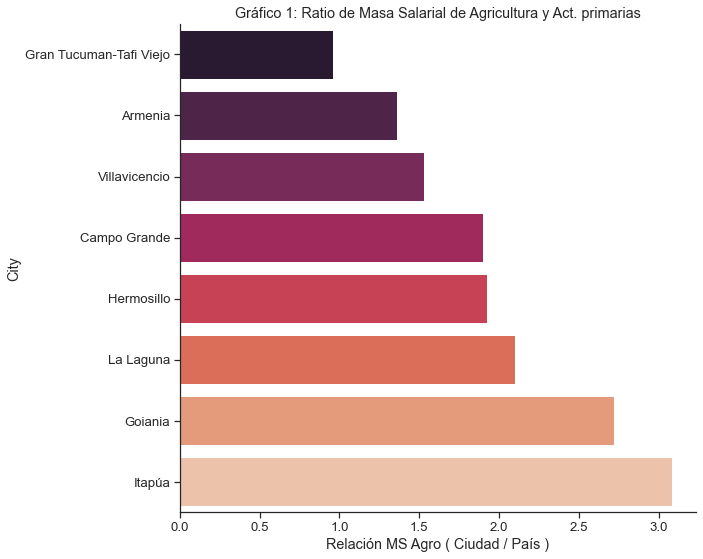

In [119]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Relación MS Agro ( Ciudad / País )', y=sel_agro.sort_values('Relación MS Agro ( Ciudad / País )').index.get_level_values(1), data=sel_agro.sort_values('Relación MS Agro ( Ciudad / País )') , palette='rocket' , orient='h' ).set_title('Gráfico 1: Ratio de Masa Salarial de Agricultura y Act. primarias')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
#plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/sel_agro.png",bbox_inches='tight')
plt.tight_layout()

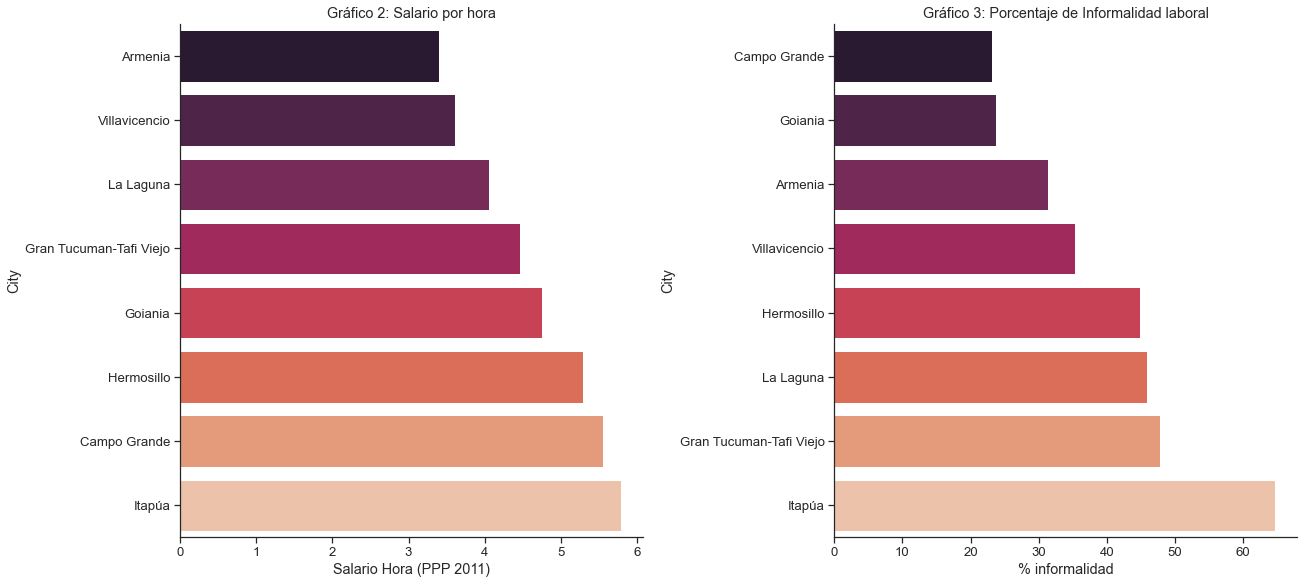

In [117]:
f, axes = plt.subplots(1, 2,figsize=(18,8),constrained_layout=True)

sns.barplot(x='Salario Hora (PPP 2011)', y=sel_agro.sort_values('Salario Hora (PPP 2011)').index.get_level_values(1) , data=sel_agro.sort_values('Salario Hora (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 2: Salario por hora')
sns.barplot(x='% informalidad', y=sel_agro.sort_values('% informalidad').index.get_level_values(1) , data=sel_agro.sort_values('% informalidad'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 3: Porcentaje de Informalidad laboral')

sns.set(font_scale=1.2)
sns.set_style("ticks") #, {"xtick.major.size": 8, "ytick.major.size": 3}
sns.despine()
plt.ticklabel_format(style='plain', axis='x')

#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/sel_agro_23.png",bbox_inches='tight') 
#plt.tight_layout()

Baja Tec

In [121]:
sectores.sort_values(['Country','ratio_Baja Tec'],ascending=[True,False]).loc[(sectores['pops']>500000)&(sectores['pops']<5000000),['pops','ratio_Baja Tec']].groupby('Country').head(5)

pops  ratio_Baja Tec
Country    City                                                           
Argentina  Mar del Plata-Batan                      656456           1.809
           Gran Rosario                            1198528           1.456
           Ciudad de Buenos Aires                  3075646           1.213
           Gran Cordoba                            1430000           1.091
           Salta                                    533303           0.989
Bolivia    Cercado/Cochabamba                      1916000           1.301
           Pedro Domingo Murillo/La Paz y el Alto  2867504           1.286
           Andrés Ibañez/Santa Cruz de la Sierra   3151676           1.143
Brasil     Fortaleza                               2643000           2.086
           Cuiaba                                   765000           1.695
           Goiania                                 1302000           1.469
           Natal                                    803739           1.395
           Curitiba                                3595662           1.272
Colombia   Medellin                                2427000           1.912
           Bucaramanga                              581130           1.671
           Cucuta                                   750000           1.626
           Ibague                                   529635           1.547
           Cali                                    2228000           1.501
Costa Rica Liberia                                 4818977           1.124
Ecuador    Guayaquil                               2291000           1.120
           Quito                                   1619000           0.877
           Esmeraldas                               643654           0.386
Mexico     Tlaxcala-Apizaco                        1273000           2.596
           Puebla-Tlaxcala                         1576000           2.183
           La Laguna                               1215817           1.492
           Guadalajara                             1495000           1.270
           Pachuca                                  557093           1.056
Paraguay   Central                                 2201000           1.359
           Alto Paraná                              830943           0.955
           Itapúa                                   608215           0.912
           Asunción                                 525294           0.621
Peru       Trujillo                                 919899           2.196
           Arequipa -area metropolitana            1008000           1.466
           Chiclayo                                 552508           1.252
Uruguay    Montevideo                              1381000           0.638

In [122]:
baja_list=['Gran Rosario'
,'Mar del Plata-Batan'
,'Fortaleza'
,'Cuiaba'
,'Medellin'
,'Bucamaranga'
,'Tlaxcala-Apizaco'
,'Puebla-Tlaxcala'
,'Trujillo']

In [123]:
sel_baja = cwpops.loc[cwpops.index.get_level_values(1).isin(baja_list),['pops']].join(shares_cutoff.loc[:,'cutoff_8'],how='inner').join(
    eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').rename(columns={'cutoff_8':'% m. salarial en < 8hs','pops':'Población estimada',
    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('Duración desempleo (meses)', 'Total'):'Duración desempleo',
    ('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)',
    'Salario Horario (PPP 2011)'):'Salario Hora (PPP 2011)'}).join(sectores['ratio_Baja Tec']).rename(columns={'ratio_Baja Tec':'Relación MS Baja Tec ( Ciudad / País )'})

In [124]:
sel_baja['Población estimada'] = sel_baja['Población estimada'].apply(lambda x : "{:,}".format(x))
sel_baja['% m. salarial en < 8hs'] = sel_baja['% m. salarial en < 8hs'].apply(lambda x :x*100)

In [125]:
cols = sel_baja.columns.tolist()

cols = [cols[0]] + [cols[-1]] + cols[2:-1] + [cols[1]]

In [126]:
sel_baja = sel_baja[cols]

In [127]:
sel_baja.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/baja.html')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/images/baja.html'

In [128]:
sel_baja

Población estimada  \
Country   City                                     
Argentina Gran Rosario                 1,198,528   
          Mar del Plata-Batan            656,456   
Brasil    Cuiaba                         765,000   
          Fortaleza                    2,643,000   
Colombia  Medellin                     2,427,000   
Mexico    Puebla-Tlaxcala              1,576,000   
          Tlaxcala-Apizaco             1,273,000   
Peru      Trujillo                       919,899   

                               Relación MS Baja Tec ( Ciudad / País )  \
Country   City                                                          
Argentina Gran Rosario                                          1.456   
          Mar del Plata-Batan                                   1.809   
Brasil    Cuiaba                                                1.695   
          Fortaleza                                             2.086   
Colombia  Medellin                                              1.912   
Mexico    Puebla-Tlaxcala                                       2.183   
          Tlaxcala-Apizaco                                      2.596   
Peru      Trujillo                                              2.196   

                               Salario Hora (PPP 2011)  % informalidad  \
Country   City                                                           
Argentina Gran Rosario                           5.293          33.799   
          Mar del Plata-Batan                    6.461          36.678   
Brasil    Cuiaba                                 5.509          20.030   
          Fortaleza                              4.323          31.771   
Colombia  Medellin                               3.547          27.665   
Mexico    Puebla-Tlaxcala                        3.253          62.985   
          Tlaxcala-Apizaco                       3.273          69.132   
Peru      Trujillo                               4.260          92.151   

                               % desempleo  % Secundario Completo  \
Country   City                                                      
Argentina Gran Rosario              11.052                 46.139   
          Mar del Plata-Batan       11.301                    nan   
Brasil    Cuiaba                     8.580                 39.025   
          Fortaleza                 11.100                 38.097   
Colombia  Medellin                  13.896                 39.631   
Mexico    Puebla-Tlaxcala            3.137                 33.771   
          Tlaxcala-Apizaco           3.418                 32.888   
Peru      Trujillo                   4.627                 47.888   

                               % Superior Completo  % m. salarial en < 8hs  
Country   City                                                              
Argentina Gran Rosario                      13.994                  81.574  
          Mar del Plata-Batan               13.182                  74.219  
Brasil    Cuiaba                            11.132                   1.122  
          Fortaleza                          9.954                   4.153  
Colombia  Medellin                           7.865                  33.312  
Mexico    Puebla-Tlaxcala                   14.053                  39.652  
          Tlaxcala-Apizaco                  12.492                  42.306  
Peru      Trujillo                          17.821                  14.232

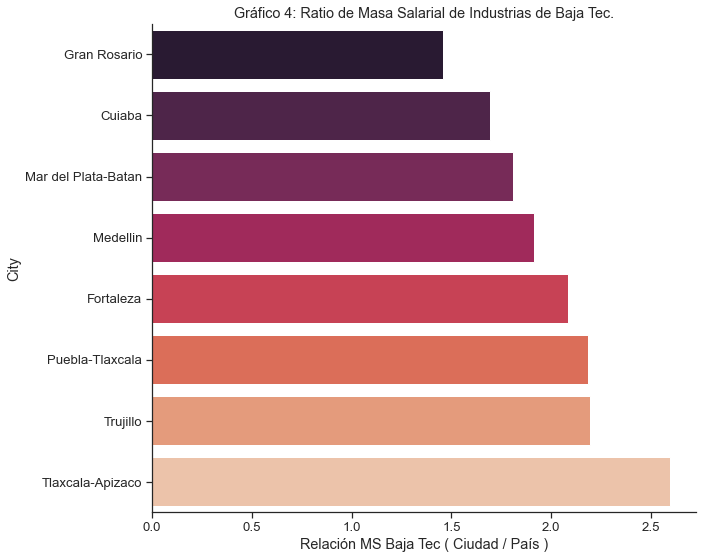

In [129]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Relación MS Baja Tec ( Ciudad / País )', y=sel_baja.sort_values('Relación MS Baja Tec ( Ciudad / País )').index.get_level_values(1), data=sel_baja.sort_values('Relación MS Baja Tec ( Ciudad / País )') , palette='rocket' , orient='h' ).set_title('Gráfico 4: Ratio de Masa Salarial de Industrias de Baja Tec.')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
#plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/sel_baja.png",bbox_inches='tight')
plt.tight_layout()

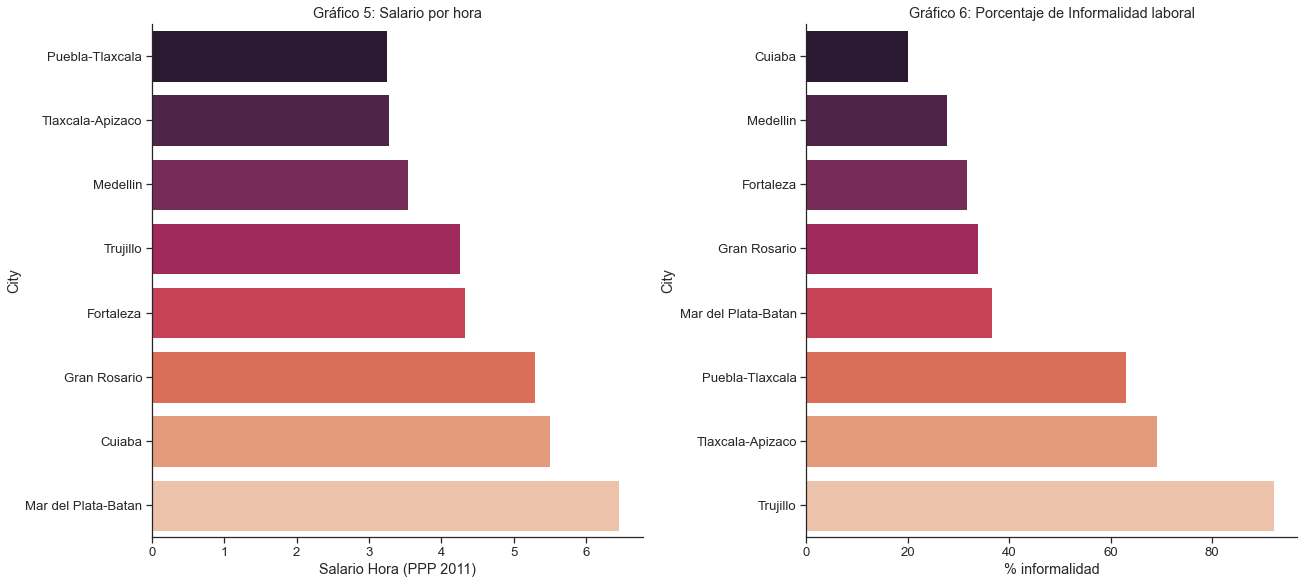

In [130]:
f, axes = plt.subplots(1, 2,figsize=(18,8),constrained_layout=True)

sns.barplot(x='Salario Hora (PPP 2011)', y=sel_baja.sort_values('Salario Hora (PPP 2011)').index.get_level_values(1) , data=sel_baja.sort_values('Salario Hora (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 5: Salario por hora')
sns.barplot(x='% informalidad', y=sel_baja.sort_values('% informalidad').index.get_level_values(1) , data=sel_baja.sort_values('% informalidad'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 6: Porcentaje de Informalidad laboral')

sns.set(font_scale=1.2)
sns.set_style("ticks") #, {"xtick.major.size": 8, "ytick.major.size": 3}
sns.despine()
plt.ticklabel_format(style='plain', axis='x')

#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/sel_baja_23.png",bbox_inches='tight') 
#plt.tight_layout()

Resto Ind

In [131]:
resto_list=['Gran Cordoba'
,'Curitiba'
#,'Manaus'
,'Belo Horizonte'
,'Cali'
,'Guayaquil'
,'Juárez'
#,'Saltillo'
#,'San Luis Potosí'
,'Tijuana'
,'Arequipa -area metropolitana']

In [132]:
sectores.sort_values(['Country','ratio_Resto Ind'],ascending=[True,False]).loc[(sectores['pops']>500000)&(sectores['pops']<5000000),['pops','ratio_Resto Ind']].groupby('Country').head(5)

pops  ratio_Resto Ind
Country    City                                                            
Argentina  Gran Rosario                            1198528            1.604
           Gran Cordoba                            1430000            1.509
           Ciudad de Buenos Aires                  3075646            1.503
           Gran Tucuman-Tafi Viejo                 1448188            0.966
           Mar del Plata-Batan                      656456            0.862
Bolivia    Andrés Ibañez/Santa Cruz de la Sierra   3151676              nan
           Cercado/Cochabamba                      1916000              nan
           Pedro Domingo Murillo/La Paz y el Alto  2867504              nan
Brasil     Manaus                                  1793000            3.283
           Curitiba                                3595662            2.189
           Salvador                                2677000            1.494
           Belo Horizonte                          1433000            1.477
           Porto Alegre                            1409000            1.244
Colombia   Cali                                    2228000            2.044
           Barranquilla                            1274250            1.834
           Medellin                                2427000            1.794
           Cartagena                                914552            1.542
           Bucaramanga                              581130            1.342
Costa Rica Liberia                                 4818977            0.490
Ecuador    Guayaquil                               2291000            1.807
           Quito                                   1619000            1.391
           Esmeraldas                               643654            0.610
Mexico     Juárez                                  1321000            3.333
           Saltillo                                 709671            2.586
           San Luis Potosí                          824229            1.929
           Chihuahua                                809232            1.752
           Tijuana                                 1301000            1.673
Paraguay   Central                                 2201000            1.446
           Asunción                                 525294            1.155
           Alto Paraná                              830943            0.761
           Itapúa                                   608215            0.735
Peru       Trujillo                                 919899            1.863
           Arequipa -area metropolitana            1008000            1.711
           Chiclayo                                 552508            1.010
Uruguay    Montevideo                              1381000            1.346

In [133]:
sel_resto = cwpops.loc[cwpops.index.get_level_values(1).isin(resto_list),['pops']].join(shares_cutoff.loc[:,'cutoff_8'],how='inner').join(
    eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').rename(columns={'cutoff_8':'% m. salarial en < 8hs','pops':'Población estimada',
    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('Duración desempleo (meses)', 'Total'):'Duración desempleo',
    ('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)',
    'Salario Horario (PPP 2011)'):'Salario Hora (PPP 2011)'}).join(sectores['ratio_Resto Ind']).rename(columns={'ratio_Resto Ind':'Relación MS Resto Ind ( Ciudad / País )'})

In [134]:
sel_resto['Población estimada'] = sel_resto['Población estimada'].apply(lambda x : "{:,}".format(x))
sel_resto['% m. salarial en < 8hs'] = sel_resto['% m. salarial en < 8hs'].apply(lambda x :x*100)

In [135]:
cols = sel_resto.columns.tolist()

cols = [cols[0]] + [cols[-1]] + cols[2:-1] + [cols[1]]

In [136]:
sel_resto = sel_resto[cols]

In [382]:
sel_resto.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/resto.html')

In [297]:
sel_resto

Población estimada  \
Country   City                                              
Argentina Gran Cordoba                          1,430,000   
Brasil    Belo Horizonte                        1,433,000   
          Curitiba                              3,595,662   
Colombia  Cali                                  2,228,000   
Ecuador   Guayaquil                             2,291,000   
Mexico    Juárez                                1,321,000   
          Tijuana                               1,301,000   
Peru      Arequipa -area metropolitana          1,008,000   

                                        Relación MS Resto Ind ( Ciudad / País )  \
Country   City                                                                    
Argentina Gran Cordoba                                                    1.509   
Brasil    Belo Horizonte                                                  1.477   
          Curitiba                                                        2.189   
Colombia  Cali                                                            2.044   
Ecuador   Guayaquil                                                       1.807   
Mexico    Juárez                                                          3.333   
          Tijuana                                                         1.673   
Peru      Arequipa -area metropolitana                                    1.711   

                                        Salario Hora (PPP 2011)  \
Country   City                                                    
Argentina Gran Cordoba                                    4.639   
Brasil    Belo Horizonte                                  4.830   
          Curitiba                                        5.984   
Colombia  Cali                                            4.105   
Ecuador   Guayaquil                                       4.400   
Mexico    Juárez                                          5.420   
          Tijuana                                         5.197   
Peru      Arequipa -area metropolitana                    4.433   

                                        % informalidad  % desempleo  \
Country   City                                                        
Argentina Gran Cordoba                          38.948       12.746   
Brasil    Belo Horizonte                        20.504       10.395   
          Curitiba                              16.671        8.549   
Colombia  Cali                                  39.651       12.281   
Ecuador   Guayaquil                             36.198        2.880   
Mexico    Juárez                                45.069        2.162   
          Tijuana                               54.284        4.188   
Peru      Arequipa -area metropolitana          90.769        3.420   

                                        % Secundario Completo  \
Country   City                                                  
Argentina Gran Cordoba                                    nan   
Brasil    Belo Horizonte                               39.602   
          Curitiba                                     42.430   
Colombia  Cali                                         40.257   
Ecuador   Guayaquil                                    41.354   
Mexico    Juárez                                       26.261   
          Tijuana                                      29.406   
Peru      Arequipa -area metropolitana                 57.578   

                                        % Superior Completo  \
Country   City                                                
Argentina Gran Cordoba                               14.496   
Brasil    Belo Horizonte                             10.983   
          Curitiba                                   13.257   
Colombia  Cali                                        8.584   
Ecuador   Guayaquil                                  10.438   
Mexico    Juárez                                      8.236   
          Tijuana                                     9.688 

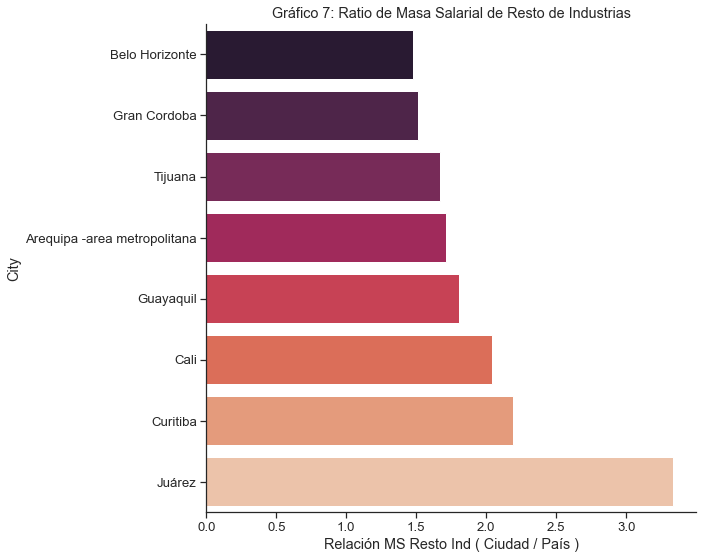

In [137]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Relación MS Resto Ind ( Ciudad / País )', y=sel_resto.sort_values('Relación MS Resto Ind ( Ciudad / País )').index.get_level_values(1), data=sel_resto.sort_values('Relación MS Resto Ind ( Ciudad / País )') , palette='rocket' , orient='h' ).set_title('Gráfico 7: Ratio de Masa Salarial de Resto de Industrias')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
#plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/sel_resto.png",bbox_inches='tight')
plt.tight_layout()

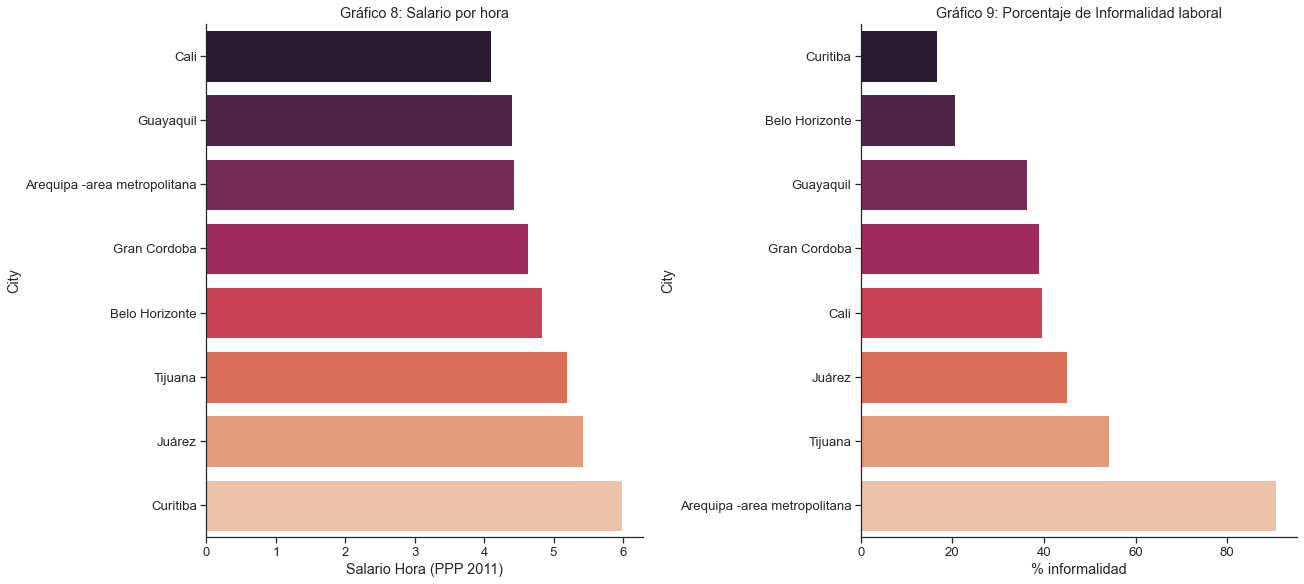

In [138]:
f, axes = plt.subplots(1, 2,figsize=(18,8),constrained_layout=True)

sns.barplot(x='Salario Hora (PPP 2011)', y=sel_resto.sort_values('Salario Hora (PPP 2011)').index.get_level_values(1) , data=sel_resto.sort_values('Salario Hora (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 8: Salario por hora')
sns.barplot(x='% informalidad', y=sel_resto.sort_values('% informalidad').index.get_level_values(1) , data=sel_resto.sort_values('% informalidad'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 9: Porcentaje de Informalidad laboral')

sns.set(font_scale=1.2)
sns.set_style("ticks") #, {"xtick.major.size": 8, "ytick.major.size": 3}
sns.despine()
plt.ticklabel_format(style='plain', axis='x')

#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/sel_resto_23.png",bbox_inches='tight') 
#plt.tight_layout()

#### Aglomerados

In [139]:
msa= pd.read_excel('files/aglomerados/msa.xlsx',index_col=[0,1]).reset_index().replace({'Brazil':'Brasil'})

In [140]:
msa['City'] = msa['City'].str.replace('ã','a')

In [141]:
msa = msa.replace({'City':{'Puebla':'Puebla-Tlaxcala'}})

In [142]:
msa['City'] = msa['City'].str.replace('á','a',regex=False).str.replace('é','e',regex=False).str.replace('í','i',regex=False).str.replace('ó','o',regex=False).str.replace('ú','u',regex=False).str.replace('â','a',regex=False)

In [143]:
notlist=[msa.iloc[:,0].unique().tolist()[2]]+[msa.iloc[:,0].unique().tolist()[7]]

In [144]:
msa_latam = msa.loc[~msa['Country'].isin(notlist)]

In [145]:
msa_latam = msa_latam.sort_values(['Country','City']).set_index(['Country','City'])

In [146]:
mylist=['Argentina',
 'Bolivia',
 'Brasil',
 'Chile',
 'Colombia',
 'Ecuador',
 'Mexico',
 'Peru',]

In [147]:
msa_latam = msa_latam.loc[(msa_latam.index.get_level_values(0).isin(mylist))&(msa_latam['pops']<10000000),:].sort_values('pops',ascending=False)

In [148]:
msa_latam.groupby('Country').head(10).sort_values(['Country','pops'],ascending=[True,False]).join(shares_cutoff.loc[:,['cutoff_9']],how='inner')

rank_continent     pops     year      Continent  \
Country  City                                                               
Brasil   Belo Horizonte                7  5829923 2015.000  South America   
         Porto Alegre                  9  4258926 2015.000  South America   
         Brasilia                     10  4201737 2015.000  South America   
         Fortaleza                    11  3985297 2015.000  South America   
         Salvador                     12  3953290 2015.000  South America   
         Recife                       13  3914397 2015.000  South America   
         Curitiba                     15  3502804 2015.000  South America   
         Manaus                       21  2523819 2015.000  South America   
Colombia Bogota                        5  9286225 2015.000  South America   
         Medellin                     14  3777009 2015.000  South America   
         Cali                         18  2911278 2015.000  South America   
         Barranquilla                 27  2025071 2015.000  South America   
         Cartagena                    46  1161320 2015.000  South America   
         Bucaramanga                  48  1122945 2015.000  South America   
Ecuador  Guayaquil                    17  2952159 2015.000  South America   
         Quito                        19  2653330 2015.000  South America   
Mexico   Guadalajara                  12  4796603      nan  North America   
         Monterrey                    17  4475949      nan  North America   
         Puebla-Tlaxcala              25  2941988      nan  North America   
         Toluca                       41  2116506      nan  North America   
         Tijuana                      50  1840710      nan  North America   

                          rank  cutoff_9  
Country  City                             
Brasil   Belo Horizonte     17     0.346  
         Porto Alegre       27     0.145  
         Brasilia           28     0.051  
         Fortaleza          30     0.053  
         Salvador           31     0.075  
         Recife             32     0.069  
         Curitiba           37     0.231  
         Manaus             51     0.020  
Colombia Bogota              9     0.714  
         Medellin           33     0.782  
         Cali               43     0.414  
         Barranquilla       71     0.139  
         Cartagena          96     0.139  
         Bucaramanga        98     0.563  
Ecuador  Guayaquil          41     0.865  
         Quito              48     0.887  
Mexico   Guadalajara        20     0.491  
         Monterrey          25     0.117  
         Puebla-Tlaxcala    42     0.424  
         Toluca             66     0.443  
         Tijuana            81     0.331

In [149]:
sel=['Gran Tucuman-Tafi Viejo',
 'Gran Mendoza',
 'Monterrey',
 'Culiacán',
 'Torreon',
 'Puebla-Tlaxcala',
 'Toluca',
 'Barranquilla',
 'Cartagena',
     'Cali',
    'Fortaleza',
    'Recife',
    'Salvador',
    'Curitiba',
    'Belo Horizonte']

In [150]:
aglomerados = cwpops.loc[cwpops.index.get_level_values(1).isin(sel),['pops']].join(shares_cutoff.loc[:,'cutoff_8'],how='inner').join(
    eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').rename(columns={'cutoff_8':'% m. salarial en < 8hs','pops':'población estimada',
    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('Duración desempleo (meses)', 'Total'):'Duración desempleo',
    ('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)',
    'Salario Horario (PPP 2011)'):'Salario Hora (PPP 2011)'})

aglomerados['población estimada'] = aglomerados['población estimada'].apply(lambda x : "{:,}".format(x))
aglomerados['% m. salarial en < 8hs'] = aglomerados['% m. salarial en < 8hs'].apply(lambda x :x*100)

In [151]:
aglomerados = aglomerados.join(msa_latam.loc[:,['pops']].rename(columns={'pops':'Pob. AEM'}),how='left')

In [152]:
idx = pd.IndexSlice

In [156]:
mylist=['Gran Mendoza','Gran Tucuman-Tafi Viejo','Culiacán']

In [158]:
aglomerados.loc[idx[:, mylist], 'Pob. AEM'] = [1400000, 1448188, 3216000]

In [185]:
aglomerados['Pob. AEM'] = aglomerados['Pob. AEM'].str.replace(',','')

In [186]:
aglomerados['Pob. AEM'] = aglomerados['Pob. AEM'].astype('int') #.apply(lambda x : "{:,}".format(x))

In [160]:
cols = aglomerados.columns.tolist()

In [161]:
cols = [cols[0]] + [cols[-1]] + cols[2:-1] + [cols[1]]

In [162]:
aglomerados = aglomerados[cols]

In [163]:
shares_cutoff['crec_ms'] = (shares_cutoff['cutoff_9'] / shares_cutoff['cutoff_0']) - 1

In [187]:
aglomerados.join(shares_cutoff.loc[:,'crec_ms'],how='inner')

población estimada  Pob. AEM  \
Country   City                                                   
Argentina Gran Mendoza                       114,822   1400000   
          Gran Tucuman-Tafi Viejo          1,448,188   1448188   
Brasil    Belo Horizonte                   1,433,000   5829923   
          Curitiba                         3,595,662   3502804   
          Fortaleza                        2,643,000   3985297   
          Recife                           1,555,000   3914397   
          Salvador                         2,677,000   3953290   
Colombia  Barranquilla                     1,274,250   2025071   
          Cali                             2,228,000   2911278   
          Cartagena                          914,552   1161320   
Mexico    Culiacán                         3,216,000   3216000   
          Monterrey                        1,136,000   4475949   
          Puebla-Tlaxcala                  1,576,000   2941988   
          Toluca                             489,333   2116506   

                                   Salario Hora (PPP 2011)  % informalidad  \
Country   City                                                               
Argentina Gran Mendoza                               4.758          37.820   
          Gran Tucuman-Tafi Viejo                    4.454          47.714   
Brasil    Belo Horizonte                             4.830          20.504   
          Curitiba                                   5.984          16.671   
          Fortaleza                                  4.323          31.771   
          Recife                                     4.439          28.605   
          Salvador                                   4.505          30.008   
Colombia  Barranquilla                               3.537          32.140   
          Cali                                       4.105          39.651   
          Cartagena                                  4.080          29.486   
Mexico    Culiacán                                   4.601          51.790   
          Monterrey                                  5.837          44.843   
          Puebla-Tlaxcala                            3.253          62.985   
          Toluca                                     4.084          60.807   

                                   % desempleo  % Secundario Completo  \
Country   City                                                          
Argentina Gran Mendoza                   8.458                 38.399   
          Gran Tucuman-Tafi Viejo       10.321                 42.952   
Brasil    Belo Horizonte                10.395                 39.602   
          Curitiba                       8.549                 42.430   
          Fortaleza                     11.100                 38.097   
          Recife                        15.437                 40.645   
          Salvador                      15.719                 39.535   
Colombia  Barranquilla                   7.416                 46.860   
          Cali                          12.281                 40.257   
          Cartagena                     10.326                 46.219   
Mexico    Culiacán                       4.359                 39.343   
          Monterrey                      3.447                 29.620   
          Puebla-Tlaxcala                3.137                 33.771   
          Toluca                         4.223                 34.925   

                                   % Superior Completo  \
Country   City                                           
Argentina Gran Mendoza                          14.489   
          Gran Tucuman-Tafi Viejo               10.203   
Brasil    Belo Horizonte                        10.983   
          Curitiba                              13.257   
          Fortaleza                              9.954   
          Recife                                10.719   
          Salvador                               9.550   
Colombia  Barranquilla               

In [165]:
a = sel_agro.columns.tolist()
a.pop(1)

'Relación MS Agro ( Ciudad / País )'

In [166]:
sel_sec = sel_agro.append(sel_resto).append(sel_baja).loc[:,a]

In [207]:
cruce = aglomerados.merge(sel_sec.iloc[:,0],left_index=True,right_index=True,how='left',indicator=True).drop(columns=['Población estimada'])

In [208]:
cruce = cruce[cruce['_merge']=='left_only'].drop(columns=['_merge'])

In [209]:
cruce

población estimada  Pob. AEM  Salario Hora (PPP 2011)  \
Country   City                                                                 
Argentina Gran Mendoza            114,822   1400000                    4.758   
Brasil    Recife                1,555,000   3914397                    4.439   
          Salvador              2,677,000   3953290                    4.505   
Colombia  Barranquilla          1,274,250   2025071                    3.537   
          Cartagena               914,552   1161320                    4.080   
Mexico    Culiacán              3,216,000   3216000                    4.601   
          Monterrey             1,136,000   4475949                    5.837   
          Toluca                  489,333   2116506                    4.084   

                        % informalidad  % desempleo  % Secundario Completo  \
Country   City                                                               
Argentina Gran Mendoza          37.820        8.458                 38.399   
Brasil    Recife                28.605       15.437                 40.645   
          Salvador              30.008       15.719                 39.535   
Colombia  Barranquilla          32.140        7.416                 46.860   
          Cartagena             29.486       10.326                 46.219   
Mexico    Culiacán              51.790        4.359                 39.343   
          Monterrey             44.843        3.447                 29.620   
          Toluca                60.807        4.223                 34.925   

                        % Superior Completo  % m. salarial en < 8hs  
Country   City                                                       
Argentina Gran Mendoza               14.489                   7.894  
Brasil    Recife                     10.719                   6.693  
          Salvador                    9.550                   6.295  
Colombia  Barranquilla               10.078                  13.864  
          Cartagena                  10.832                  13.864  
Mexico    Culiacán                   18.460                   9.324  
          Monterrey                  11.763                  10.595  
          Toluca                     13.991                  44.036

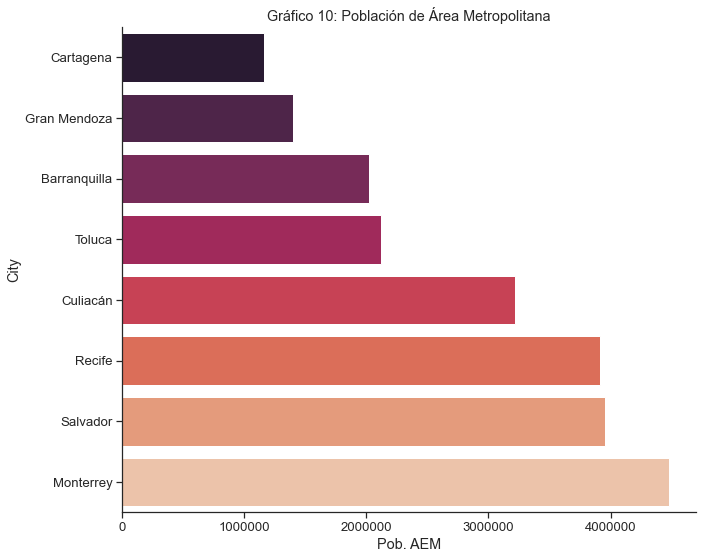

In [210]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Pob. AEM', y=cruce.sort_values('Pob. AEM').index.get_level_values(1), data=cruce.sort_values('Pob. AEM') , palette='rocket' , orient='h' ).set_title('Gráfico 10: Población de Área Metropolitana')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/aglomerados.png",bbox_inches='tight')
plt.tight_layout()

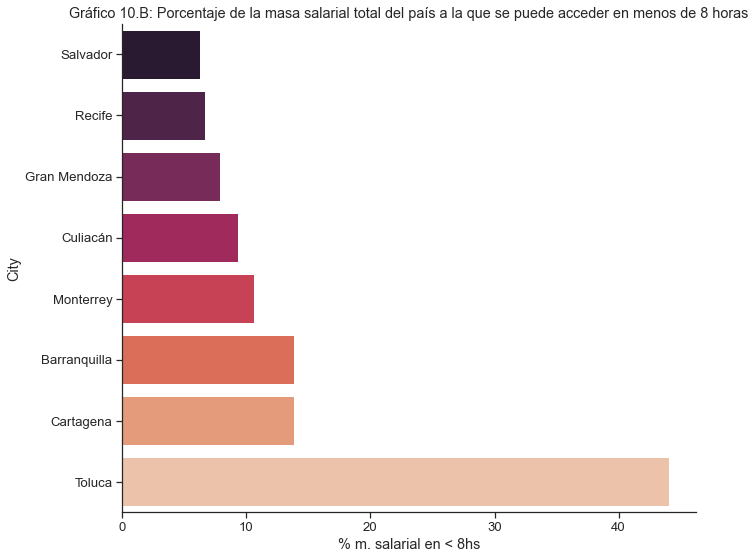

In [238]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='% m. salarial en < 8hs', y=cruce.sort_values('% m. salarial en < 8hs').index.get_level_values(1), data=cruce.sort_values('% m. salarial en < 8hs') , palette='rocket' , orient='h' ).set_title('Gráfico 10.B: Porcentaje de la masa salarial total del país a la que se puede acceder en menos de 8 horas')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/aglomerados_lejania.png",bbox_inches='tight')
plt.tight_layout()

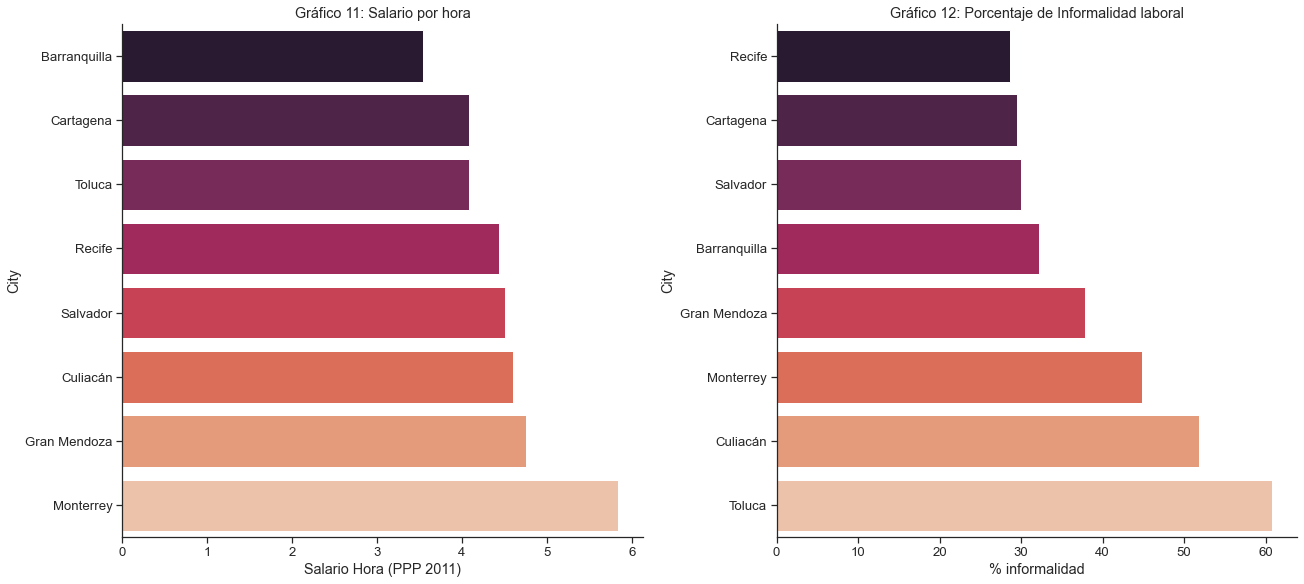

In [211]:
f, axes = plt.subplots(1, 2,figsize=(18,8),constrained_layout=True)

sns.barplot(x='Salario Hora (PPP 2011)', y=cruce.sort_values('Salario Hora (PPP 2011)').index.get_level_values(1) , data=cruce.sort_values('Salario Hora (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 11: Salario por hora')
sns.barplot(x='% informalidad', y=cruce.sort_values('% informalidad').index.get_level_values(1) , data=cruce.sort_values('% informalidad'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 12: Porcentaje de Informalidad laboral')

sns.set(font_scale=1.2)
sns.set_style("ticks") #, {"xtick.major.size": 8, "ytick.major.size": 3}
sns.despine()
plt.ticklabel_format(style='plain', axis='x')

#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/aglomerados_23.png",bbox_inches='tight') 
#plt.tight_layout()

In [212]:
cruce['Pob. AEM'] = cruce['Pob. AEM'].apply(lambda x : "{:,}".format(x))

In [213]:
cruce.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/aglomerados.html')

### Ciudades lejanas vs cercanas

Mexico

In [214]:
sc_mex = shares_cutoff.loc['Mexico'].drop(columns={'index1'})
sc_mex.join(eph.loc['Mexico'].loc[:,'Salario Horario (PPP 2011)'],how='inner').join(cwpops.loc['Mexico'].loc[:,'pops']).loc[sc_mex['cutoff_9']<0.1,:].sort_values('pops')

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms,Salario Horario (PPP 2011),pops
City,,,,,,,,,,,,,
Villahermosa,0.004,0.004,0.004,0.014,0.020,0.021,0.034,0.039,0.055,0.083,17.740,4.585,353577
Tuxtla Gutiérrez,0.006,0.006,0.007,0.007,0.021,0.023,0.023,0.033,0.039,0.051,7.380,3.775,537102
Cancún,0.008,0.008,0.008,0.008,0.019,0.020,0.023,0.023,0.023,0.023,1.742,4.625,628306
Mexicali,0.011,0.011,0.013,0.033,0.036,0.036,0.039,0.039,0.052,0.052,3.821,5.162,689775
Mérida,0.010,0.010,0.010,0.013,0.021,0.021,0.023,0.023,0.027,0.027,1.632,4.895,777615
Chihuahua,0.013,0.013,0.014,0.014,0.014,0.043,0.055,0.055,0.065,0.079,5.302,5.001,809232
Hermosillo,0.013,0.013,0.016,0.020,0.023,0.023,0.025,0.025,0.072,0.083,5.284,5.291,812229
Juárez,0.028,0.028,0.028,0.028,0.028,0.043,0.045,0.047,0.049,0.051,0.809,5.420,1321000


In [215]:
sc_mex['crec_ms'] = (sc_mex['cutoff_9'] / sc_mex['cutoff_0']) - 1

In [216]:
sc_mex.loc[(sc_mex['crec_ms']>10),:].join(cwpops.loc['Mexico'].loc[:,'pops']).sort_values('pops',ascending=False).iloc[:10,:].sort_values('crec_ms',ascending=False).iloc[:2,:]

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms,pops
City,,,,,,,,,,,,
San Luis Potosí,0.011,0.011,0.011,0.038,0.074,0.317,0.383,0.437,0.474,0.498,43.218,824229
Acapulco,0.009,0.009,0.010,0.012,0.015,0.257,0.286,0.305,0.350,0.380,41.648,863431


### Brasil

In [217]:
sc_bra = shares_cutoff.loc['Brasil'].drop(columns={'index1'})
sc_bra.join(eph.loc['Brasil'].loc[:,'Salario Horario (PPP 2011)'],how='inner').join(cwpops.loc['Brasil'].loc[:,'pops']).loc[sc_bra['cutoff_9']<0.1,:].sort_values('pops')

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms,Salario Horario (PPP 2011),pops
City,,,,,,,,,,,,,
Belem,0.002,0.002,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.007,3.407,3.991,143474
Vitoria,0.003,0.003,0.003,0.005,0.005,0.010,0.015,0.020,0.025,0.037,11.407,5.421,211529
Palmas,0.003,0.003,0.003,0.003,0.003,0.003,0.004,0.004,0.004,0.007,1.495,4.659,217056
Boa Vista,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.000,5.501,277799
Porto Velho,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.009,0.009,1.089,5.068,369259
Macapa,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.000,5.051,369287
Rio Branco,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.009,0.009,0.919,5.016,407319
Joao Pessoa,0.009,0.009,0.033,0.041,0.044,0.056,0.056,0.060,0.060,0.069,6.775,4.556,720954
Cuiaba,0.009,0.009,0.009,0.009,0.011,0.011,0.011,0.011,0.011,0.011,0.185,5.509,765000


In [218]:
sc_bra['crec_ms'] = (sc_bra['cutoff_9'] / sc_bra['cutoff_0']) - 1

In [219]:
sc_bra.loc[(sc_bra['crec_ms']>10),:].join(cwpops.loc['Brasil'].loc[:,'pops']).sort_values('pops',ascending=False).iloc[:10,:].sort_values('crec_ms',ascending=False)

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms,pops
City,,,,,,,,,,,,
Londrina,0.007,0.009,0.013,0.019,0.028,0.041,0.125,0.148,0.199,0.224,30.866,433369
Joinville,0.007,0.007,0.073,0.084,0.088,0.091,0.097,0.132,0.176,0.212,30.512,414972
Ribeirao Preto,0.008,0.008,0.021,0.050,0.063,0.097,0.111,0.113,0.148,0.227,27.642,502760
Florianopolis,0.009,0.009,0.012,0.030,0.088,0.090,0.129,0.134,0.140,0.187,18.897,477798
Uberlandia,0.008,0.008,0.012,0.012,0.026,0.058,0.087,0.096,0.105,0.147,18.039,488982
Volta Redonda,0.007,0.007,0.008,0.018,0.028,0.060,0.082,0.091,0.111,0.124,17.704,407130
Juiz de Fora,0.006,0.006,0.008,0.014,0.022,0.032,0.045,0.052,0.094,0.116,17.122,453002
Belo Horizonte,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.122,0.346,0.346,15.308,1433000
Aracaju,0.007,0.007,0.007,0.009,0.012,0.062,0.062,0.069,0.089,0.106,13.576,623000


Colombia

In [220]:
sc_col = shares_cutoff.loc['Colombia'].drop(columns={'index1'})
sc_col.join(eph.loc['Colombia'].loc[:,'Salario Horario (PPP 2011)'],how='inner').join(cwpops.loc['Colombia'].loc[:,'pops']).loc[sc_col['cutoff_9']<0.2,:].sort_values('pops')

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms,Salario Horario (PPP 2011),pops
City,,,,,,,,,,,,,
Riohacha,0.009,0.009,0.009,0.025,0.040,0.085,0.085,0.116,0.116,0.124,13.566,3.692,244836
Sincelejo,0.008,0.008,0.008,0.054,0.054,0.099,0.114,0.130,0.130,0.146,16.937,4.050,277773
Pasto,0.016,0.016,0.016,0.016,0.016,0.016,0.027,0.027,0.115,0.127,7.047,3.536,460638
Valledupar,0.015,0.015,0.015,0.015,0.040,0.085,0.093,0.124,0.171,0.171,10.280,3.272,490075
Santa Marta,0.016,0.016,0.061,0.069,0.085,0.116,0.116,0.124,0.139,0.146,8.023,3.839,515556
Cucuta,0.023,0.023,0.023,0.023,0.023,0.023,0.048,0.048,0.055,0.055,1.415,4.064,750000
Cartagena,0.031,0.031,0.031,0.076,0.084,0.115,0.115,0.139,0.139,0.139,3.404,4.080,914552
Barranquilla,0.045,0.045,0.061,0.092,0.092,0.124,0.124,0.139,0.139,0.139,2.099,3.537,1274250


In [221]:
sc_col['crec_ms'] = (sc_col['cutoff_9'] / sc_col['cutoff_0']) - 1

In [222]:
sc_col.loc[(sc_col['crec_ms']>10),:].join(cwpops.loc['Colombia'].loc[:,'pops']).sort_values('pops',ascending=False).iloc[:10,:].sort_values('crec_ms',ascending=False)

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms,pops
City,,,,,,,,,,,,
Neiva,0.012,0.012,0.012,0.012,0.030,0.036,0.408,0.538,0.680,0.687,54.978,316033
Ibague,0.018,0.018,0.018,0.018,0.498,0.531,0.575,0.670,0.782,0.819,43.940,529635
Manizales,0.017,0.017,0.044,0.152,0.158,0.371,0.371,0.742,0.765,0.773,43.378,434403
Pereira,0.022,0.027,0.158,0.158,0.264,0.371,0.386,0.398,0.758,0.765,33.035,590554
Villavicencio,0.019,0.019,0.019,0.379,0.379,0.387,0.405,0.405,0.417,0.525,26.816,527668
Popayan,0.011,0.011,0.011,0.099,0.105,0.217,0.255,0.291,0.291,0.309,26.759,300837
Bucaramanga,0.025,0.025,0.025,0.032,0.032,0.032,0.055,0.063,0.185,0.563,21.146,581130
Sincelejo,0.008,0.008,0.008,0.054,0.054,0.099,0.114,0.130,0.130,0.146,16.937,277773
Monteria,0.014,0.014,0.014,0.023,0.023,0.054,0.054,0.099,0.130,0.237,15.353,460223


Argentina

In [223]:
sc_arg = shares_cutoff.loc['Argentina'].drop(columns={'index1'})
sc_arg.join(eph.loc['Argentina'].loc[:,'Salario Horario (PPP 2011)'],how='inner').join(cwpops.loc['Argentina'].loc[:,'pops']).loc[sc_arg['cutoff_9']<0.2,:].sort_values('pops')

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms,Salario Horario (PPP 2011),pops
City,,,,,,,,,,,,,
Rawson-Trelew,0.001,0.001,0.001,0.001,0.001,0.001,0.016,0.016,0.016,0.040,38.750,6.046,26200
Ushuaia-Rio Grande,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.008,0.008,1.417,7.437,56956
Viedma-Carmen de Patagones,0.003,0.003,0.003,0.003,0.014,0.014,0.015,0.032,0.036,0.059,18.980,4.904,80632
Rio Gallegos,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.008,0.020,3.175,7.228,95796
La Rioja,0.005,0.005,0.009,0.009,0.009,0.069,0.130,0.130,0.140,0.164,32.214,4.260,178872
Formosa,0.006,0.006,0.006,0.021,0.021,0.021,0.021,0.028,0.028,0.046,7.002,4.086,222226
Comodoro Rivadavia-Rada Tilly,0.012,0.012,0.012,0.012,0.012,0.012,0.013,0.013,0.013,0.018,0.491,6.672,242351
Jujuy-Palpala,0.007,0.007,0.020,0.020,0.020,0.061,0.080,0.080,0.085,0.090,12.325,3.905,265249
Posadas,0.007,0.007,0.007,0.007,0.015,0.022,0.022,0.033,0.033,0.041,4.917,4.337,275988


In [224]:
sc_arg['crec_ms'] = (sc_arg['cutoff_9'] / sc_arg['cutoff_0']) - 1

In [225]:
sc_arg.loc[(sc_arg['crec_ms']>10),:].join(cwpops.loc['Argentina'].loc[:,'pops']).sort_values('pops',ascending=False).iloc[:10,:].sort_values('crec_ms',ascending=False)

,cutoff_0,cutoff_1,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,crec_ms,pops
City,,,,,,,,,,,,
Gran Parana,0.008,0.021,0.021,0.063,0.073,0.073,0.766,0.780,0.815,0.822,104.223,247863
Bahia Blanca-Cerri,0.011,0.011,0.011,0.011,0.018,0.021,0.045,0.058,0.721,0.733,64.266,309544
Gran Santa Fe,0.013,0.021,0.063,0.068,0.073,0.611,0.780,0.788,0.815,0.839,63.974,405683
Neuquen-Plottier,0.013,0.013,0.013,0.013,0.508,0.508,0.508,0.526,0.529,0.535,39.534,341301
Mar del Plata-Batan,0.023,0.023,0.023,0.027,0.027,0.684,0.695,0.695,0.742,0.749,30.948,656456
Gran Rosario,0.042,0.047,0.060,0.068,0.717,0.780,0.780,0.784,0.816,0.843,19.100,1198528
Gran Cordoba,0.044,0.044,0.044,0.051,0.051,0.111,0.153,0.197,0.861,0.876,18.842,1430000
Gran Resistencia,0.007,0.016,0.016,0.021,0.021,0.028,0.028,0.046,0.073,0.115,14.474,291720
Jujuy-Palpala,0.007,0.007,0.020,0.020,0.020,0.061,0.080,0.080,0.085,0.090,12.325,265249


In [226]:
mylist =['Bahia Blanca-Cerri'
,'Neuquen-Plottier'
,'Manizales'
,'Pereira'
,'Florianopolis'
,'Aracaju'
,'San Luis Potosí'
,'Acapulco']

In [227]:
sel_cerca = cwpops.loc[cwpops.index.get_level_values(1).isin(mylist),['pops']].join(shares_cutoff.loc[:,'crec_ms'],how='inner').join(
    eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').rename(columns={'crec_ms':'Multiplo M. Salarial en < 9hs','pops':'Población estimada',
    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('Duración desempleo (meses)', 'Total'):'Duración desempleo',
    ('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)',
    'Salario Horario (PPP 2011)'):'Salario Hora (PPP 2011)'})

sel_cerca['Población estimada'] = sel_cerca['Población estimada'].apply(lambda x : "{:,}".format(x))
#sel_cerca['Multiplo M. Salarial en < 9hs'] = sel_cerca['Multiplo M. Salarial en < 9hs'].apply(lambda x :x*100)

In [231]:
sel_cerca.dtypes

Población estimada                object
Multiplo M. Salarial en < 9hs    float64
Salario Hora (PPP 2011)          float64
% informalidad                   float64
% desempleo                      float64
% Secundario Completo            float64
% Superior Completo              float64
dtype: object

In [232]:
sel_cerca.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/cerca.html')

In [229]:
sel_cerca

Población estimada  \
Country   City                                    
Argentina Bahia Blanca-Cerri            309,544   
          Neuquen-Plottier              341,301   
Brasil    Aracaju                       623,000   
          Florianopolis                 477,798   
Colombia  Manizales                     434,403   
          Pereira                       590,554   
Mexico    San Luis Potosí               824,229   
          Acapulco                      863,431   

                              Multiplo M. Salarial en < 9hs  \
Country   City                                                
Argentina Bahia Blanca-Cerri                         64.266   
          Neuquen-Plottier                           39.534   
Brasil    Aracaju                                    13.576   
          Florianopolis                              18.897   
Colombia  Manizales                                  43.378   
          Pereira                                    33.035   
Mexico    San Luis Potosí                            43.218   
          Acapulco                                   41.648   

                              Salario Hora (PPP 2011)  % informalidad  \
Country   City                                                          
Argentina Bahia Blanca-Cerri                    6.497          29.321   
          Neuquen-Plottier                      6.575          21.160   
Brasil    Aracaju                               4.425          30.172   
          Florianopolis                         5.935          10.312   
Colombia  Manizales                             3.194          27.924   
          Pereira                               3.289          31.836   
Mexico    San Luis Potosí                       4.573          48.059   
          Acapulco                              2.608          69.588   

                              % desempleo  % Secundario Completo  \
Country   City                                                     
Argentina Bahia Blanca-Cerri        9.010                 49.041   
          Neuquen-Plottier          4.476                 32.309   
Brasil    Aracaju                  16.098                 36.909   
          Florianopolis             6.505                 43.246   
Colombia  Manizales                 6.761                 39.311   
          Pereira                   7.636                 37.533   
Mexico    San Luis Potosí           3.152                 32.462   
          Acapulco                  4.105                 28.840   

                              % Superior Completo  
Country   City                                     
Argentina Bahia Blanca-Cerri               15.706  
          Neuquen-Plottier                 14.140  
Brasil    Aracaju                          10.539  
          Florianopolis                    14.023  
Colombia  Manizales                         7.780  
          Pereira                           7.210  
Mexico    San Luis Potosí                  13.320  
          Acapulco                          9.225

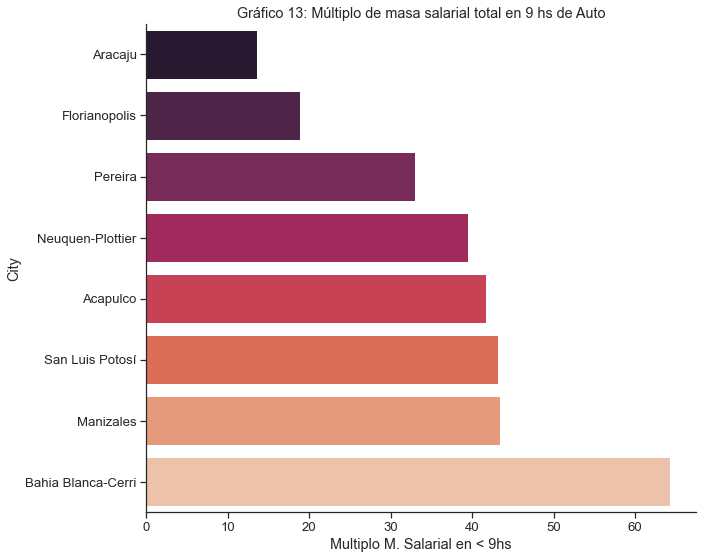

In [235]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Multiplo M. Salarial en < 9hs', y=sel_cerca.sort_values('Multiplo M. Salarial en < 9hs').index.get_level_values(1), data=sel_cerca.sort_values('Multiplo M. Salarial en < 9hs') , palette='rocket' , orient='h' ).set_title('Gráfico 13: Múltiplo de masa salarial total en 9 hs de Auto')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/cerca.png",bbox_inches='tight')
plt.tight_layout()

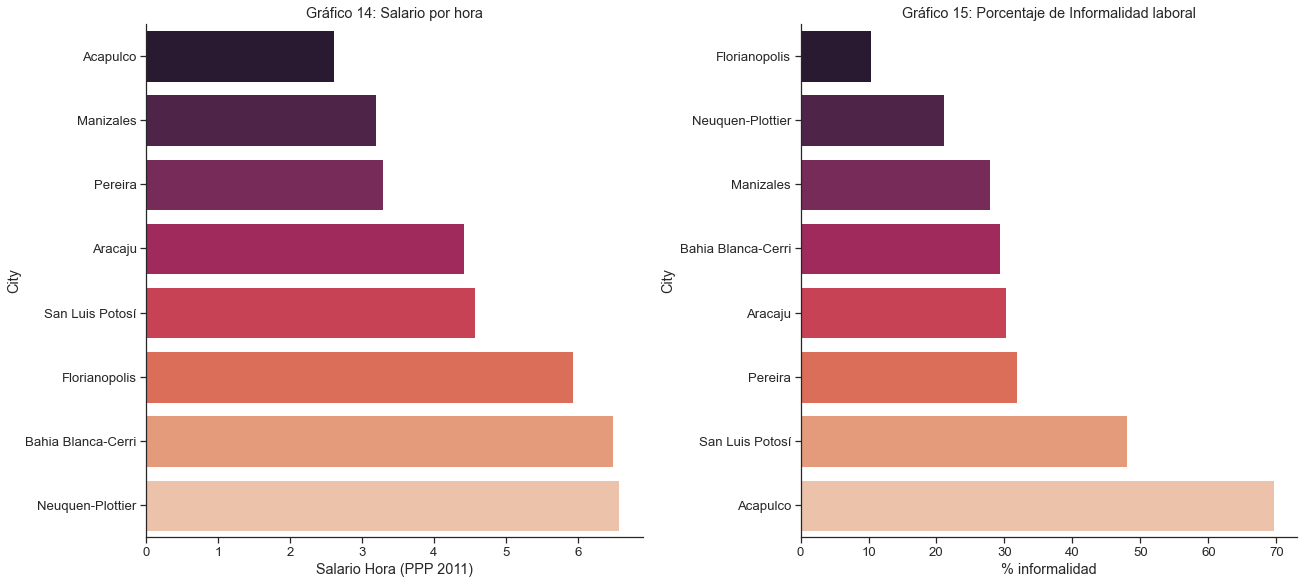

In [237]:
f, axes = plt.subplots(1, 2,figsize=(18,8),constrained_layout=True)

sns.barplot(x='Salario Hora (PPP 2011)', y=sel_cerca.sort_values('Salario Hora (PPP 2011)').index.get_level_values(1) , data=sel_cerca.sort_values('Salario Hora (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 14: Salario por hora')
sns.barplot(x='% informalidad', y=sel_cerca.sort_values('% informalidad').index.get_level_values(1) , data=sel_cerca.sort_values('% informalidad'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 15: Porcentaje de Informalidad laboral')

sns.set(font_scale=1.2)
sns.set_style("ticks") #, {"xtick.major.size": 8, "ytick.major.size": 3}
sns.despine()
plt.ticklabel_format(style='plain', axis='x')

#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion/images/cerca_23.png",bbox_inches='tight') 
#plt.tight_layout()